In [114]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/cartrain')
else:
    path = Path('')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [115]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [116]:
df = pd.read_csv(path/'train.csv')

In [117]:
df

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000
...,...,...,...,...,...,...,...,...,...,...
1637,hyundai,2017,petrol,120000 miles,left,white,sedan,good,2.0,12400
1638,toyota,2014,petrol,170000 km,left,black,sedan,good,2.0,16500
1639,nissan,2018,petrol,68900 miles,left,blue,suv,good,2.0,19500
1640,nissan,2019,petrol,31000 miles,left,black,suv,excellent,2.0,19500


In [118]:
df.isna().sum()

model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
price           0
dtype: int64

In [119]:
modes = df.mode().iloc[0]
modes

model           mercedes-benz
year                     2019
motor_type             petrol
running            300000  km
wheel                    left
color                   black
type                    sedan
status              excellent
motor_volume              2.0
price                   15750
Name: 0, dtype: object

In [120]:
df.fillna(modes, inplace=True)

We can now check there's no missing values left:

In [121]:
df.isna().sum()

model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
price           0
dtype: int64

In [122]:
import numpy as np

df.describe(include=(np.number))

,year,motor_volume,price
count,1642.000000,1642.000000,1642.000000
mean,2014.805725,2.035018,15982.633374
std,6.587573,0.253069,7176.084647
min,1987.000000,0.200000,462.000000
25%,2013.000000,2.000000,12000.000000
50%,2017.000000,2.000000,15750.000000
75%,2019.000000,2.000000,18500.000000
max,2023.000000,4.000000,87000.000000


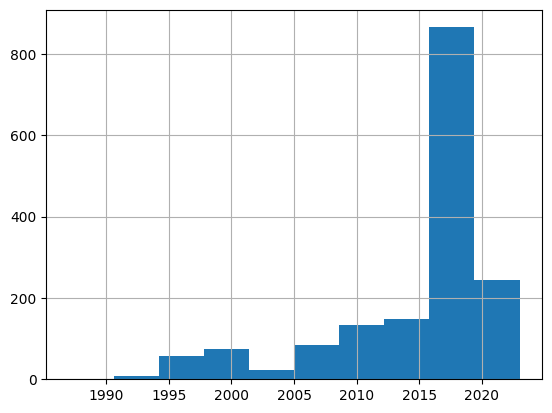

In [123]:
df['year'].hist();

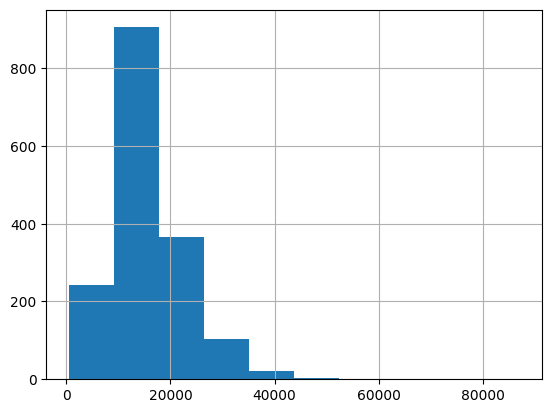

In [124]:
df['price'].hist();

In [125]:
df.describe(include=[object])

,model,motor_type,running,wheel,color,type,status
count,1642,1642,1642,1642,1642,1642,1642
unique,5,5,643,1,17,7,5
top,mercedes-benz,petrol,300000 km,left,black,sedan,excellent
freq,402,1420,19,1642,541,1276,1200


In [126]:
indep_cols = [
    "year",
    "running",
    "wheel",
    "motor_volume",
    # One-hot encoded color columns
    "color_beige", "color_black", "color_blue", "color_brown", "color_cherry",
    "color_clove", "color_golden", "color_gray", "color_green", "color_orange",
    "color_other", "color_pink", "color_purple", "color_red", "color_silver",
    "color_skyblue", "color_white",
    # One-hot encoded type columns
    "type_Coupe", "type_Universal", "type_hatchback", "type_minivan / minibus",
    "type_pickup", "type_sedan", "type_suv",
    "status_crashed", "status_excellent", "status_good", "status_new", "status_normal",
    "model_hyundai", "model_kia", "model_mercedes-benz", "model_nissan", "model_toyota",
    "motor_type_diesel", "motor_type_gas", "motor_type_hybrid",
    "motor_type_petrol", "motor_type_petrol and gas"
]


In [127]:
df['running'].dtype
df['running'].head()

0         3000  km
1       132000  km
2     95000  miles
3    137000  miles
4       130000  km
Name: running, dtype: object

In [128]:
import pandas as pd

def dataNormalize(df, mode="train"):

    df[['number', 'unit']] = df['running'].str.split(expand=True)
    df['number'] = df['number'].astype(float)
    
    df.loc[df['unit'] == 'miles', 'number'] *= 1.60934
    df['running'] = df['number']
  
    df.drop(columns=['number', 'unit'], inplace=True)

    df["running"] = pd.to_numeric(df["running"], errors="coerce")

    if mode == "train":
        df['price'] = df['price'].astype(float)
    
    
    categorical_columns = ["color", "type", "status", "model", "motor_type"]
    df = pd.get_dummies(df, columns=categorical_columns, dtype=int, prefix=categorical_columns)

    # Set 'wheel' column to 1 for all rows
    df["wheel"] = 1  

    return df


In [129]:
df = dataNormalize(df)

In [130]:
df[indep_cols].dtypes
df[indep_cols].head()

,year,running,wheel,motor_volume,color_beige,color_black,color_blue,color_brown,color_cherry,color_clove,...,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_diesel,motor_type_gas,motor_type_hybrid,motor_type_petrol,motor_type_petrol and gas
0,2022,3000.00,1,2.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2014,132000.00,1,2.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2018,152887.30,1,2.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,2002,220479.58,1,3.2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,2017,130000.00,1,2.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [131]:
from torch import tensor

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_dep = tensor(df.price.values, dtype=torch.float)

In [132]:
t_dep
n_coeff = t_indep.shape[1]

In [133]:
df

,year,running,wheel,motor_volume,price,color_beige,color_black,color_blue,color_brown,color_cherry,...,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_diesel,motor_type_gas,motor_type_hybrid,motor_type_petrol,motor_type_petrol and gas
0,2022,3000.000,1,2.0,24500.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2014,132000.000,1,2.0,25500.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2018,152887.300,1,2.0,11700.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,2002,220479.580,1,3.2,12000.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,2017,130000.000,1,2.0,26000.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,2017,193120.800,1,2.0,12400.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1638,2014,170000.000,1,2.0,16500.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1639,2018,110883.526,1,2.0,19500.0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1640,2019,49889.540,1,2.0,19500.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [134]:
print(df.dtypes)

year                           int64
running                      float64
wheel                          int64
motor_volume                 float64
price                        float64
color_beige                    int64
color_black                    int64
color_blue                     int64
color_brown                    int64
color_cherry                   int64
color_clove                    int64
color_golden                   int64
color_gray                     int64
color_green                    int64
color_orange                   int64
color_other                    int64
color_pink                     int64
color_purple                   int64
color_red                      int64
color_silver                   int64
color_skyblue                  int64
color_white                    int64
type_Coupe                     int64
type_Universal                 int64
type_hatchback                 int64
type_minivan / minibus         int64
type_pickup                    int64
t

In [135]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

Here's the number of rows and columns we have for our independent variables:

In [136]:
t_indep.shape

torch.Size([1642, 43])

In [137]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [138]:
def one_epoch(coeffs, optimizer, lr):
    optimizer.zero_grad()
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    optimizer.step()
    return round(loss.item(), 3)


In [139]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [140]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

In [141]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [142]:
feature_mean = t_indep.mean(dim=0)
feature_std = t_indep.std(dim=0)
trn_indep = (trn_indep - feature_mean) / feature_std
val_indep = (val_indep - feature_mean) / feature_std
trn_dep_mean = trn_dep.mean()
trn_dep_std = trn_dep.std()
trn_dep = (trn_dep - trn_dep_mean) / trn_dep_std
val_dep = (val_dep - trn_dep_mean) / trn_dep_std

In [143]:
print("trn_dep dtype:", trn_dep.dtype)
print("val_dep dtype:", val_dep.dtype)

trn_dep dtype: torch.float32
val_dep dtype: torch.float32


In [144]:
trn_indep = trn_indep.to(device)
trn_dep = trn_dep.to(device)
val_indep = val_indep.to(device)
val_dep = val_dep.to(device)

In [145]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [146]:
n_coeff = trn_indep.shape[1] 
n_coeff

43

In [147]:
import torch
import torch.nn as nn

class CustomNN(nn.Module):
    def __init__(self, n_coeff):
        super(CustomNN, self).__init__()
        
        self.fc1 = nn.Linear(n_coeff, 64)
        self.bn1 = nn.BatchNorm1d(64)  
        self.dropout1 = nn.Dropout(0.3) 
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(16, 1) 
        
        self.activation = nn.ReLU()  

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        return self.fc4(x)  


def init_coeffs():
    model = CustomNN(n_coeff)
    return model.to(device)


In [148]:
def calc_preds(coeffs, indeps, denormalize=False):
    preds = coeffs(indeps)
    if denormalize:
        preds = preds * trn_dep_std + trn_dep_mean
    return preds
    
def calc_loss(coeffs, indeps, deps): 
    preds = calc_preds(coeffs, indeps, denormalize=False)
    # print(preds)
    return torch.nn.functional.mse_loss(preds, deps.view(-1, 1))

In [149]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs.fc1.weight.detach().cpu().numpy()))

In [150]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()

In [151]:
losses = []
def train_model(epochs=800, lr=0.001):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    optimizer = torch.optim.Adam(coeffs.parameters(), lr=lr)
    for i in range(epochs): 
        loss = one_epoch(coeffs, optimizer, lr=lr)
        losses.append(loss)
    return coeffs

In [152]:
print(f"Using device: {device}") 
coeffs = train_model()

Using device: cuda


In [153]:
rloss = losses[:]
rloss.reverse()
print(losses[-1])
idx = 0
minv = float('inf')
for i,val in enumerate(losses):
    if val < minv:
        minv = val
        idx = i
print(idx,minv)


nan
0 inf


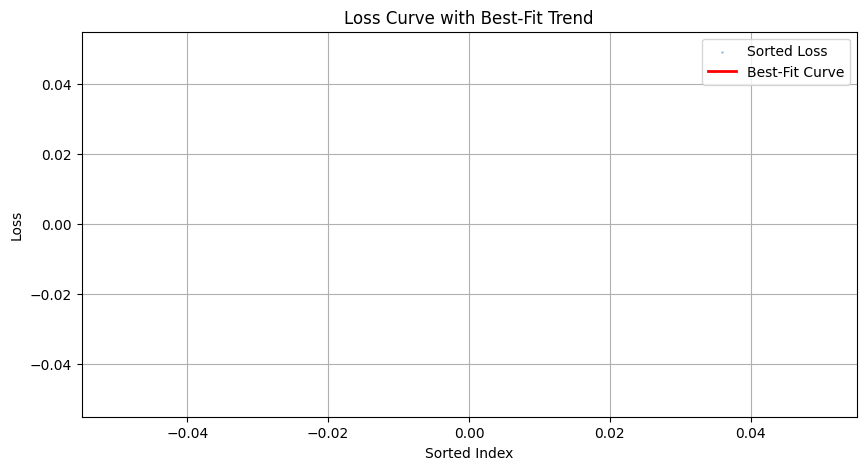

In [154]:
import numpy as np
import matplotlib.pyplot as plt
losses_sorted = losses
epochs = np.arange(1, len(losses_sorted) + 1) 

poly_coeffs = np.polyfit(epochs, losses_sorted, deg=3) 
smooth_curve = np.polyval(poly_coeffs, epochs)

plt.figure(figsize=(10, 5))
plt.scatter(epochs, losses_sorted, s=1, label="Sorted Loss", alpha=0.3)  
plt.plot(epochs, smooth_curve, color="red", linewidth=2, label="Best-Fit Curve")  

plt.xlabel("Sorted Index")
plt.ylabel("Loss")
plt.title("Loss Curve with Best-Fit Trend")
plt.legend()
plt.grid()

plt.show()

In [44]:
preds = calc_preds(coeffs, trn_indep)

In [45]:
print(f"preds dtype: {preds.dtype}, shape: {preds.shape}, min: {preds.min().item()}, max: {preds.max().item()}")
print(f"trn_dep dtype: {trn_dep.dtype}, shape: {trn_dep.shape}, min: {trn_dep.min().item()}, max: {trn_dep.max().item()}")

preds dtype: torch.float32, shape: torch.Size([1314, 1]), min: -2.673034429550171, max: 5.812140464782715
trn_dep dtype: torch.float32, shape: torch.Size([1314]), min: -1.9053051471710205, max: 9.90052604675293


In [46]:
acc(coeffs)

tensor(0.1738, device='cuda:0')

In [47]:
show_coeffs()

{'model': array([-0.34085485,  0.32525468,  0.07194891, -0.32943574, -0.22932373, -0.11713102,  0.23912333,  0.18497184], dtype=float32),
 'year': array([ 0.28076828, -0.40050027,  0.16970628,  0.0250697 ,  0.03509239,  0.28550884,  0.05684534,  0.03860956], dtype=float32),
 'motor_type': array([-3.38441044e-01, -1.00338854e-01,  1.29351392e-01, -3.29066105e-02, -1.70561398e-04, -7.12198671e-04,  1.41113028e-02,
        -2.12529470e-04], dtype=float32),
 'running': array([ 0.12627457,  0.39028287,  0.11745838, -0.21173124,  0.04841458, -0.05146429,  0.04269477,  0.07978795], dtype=float32),
 'color': array([ 0.115819  ,  0.5609784 ,  0.09314118, -0.0796786 ,  0.12832227, -0.09179835, -0.15972756,  0.05516579], dtype=float32),
 'type': array([-0.19932821, -0.46604544,  0.00117952, -0.06311921, -0.008254  ,  0.40422264, -0.46811333,  0.00901902], dtype=float32),
 'status': array([-0.24229418,  0.42968464,  0.0760955 ,  0.06050973, -0.12813468, -0.09211623,  0.16175373, -0.26084292], dtyp

In [48]:
tst_df = pd.read_csv(path/'test.csv')
tst_df

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8
...,...,...,...,...,...,...,...,...,...,...
406,406,nissan,2021,petrol,33400 km,left,black,suv,excellent,2.0
407,407,hyundai,2017,petrol,60000 miles,left,other,sedan,excellent,2.0
408,408,mercedes-benz,2012,petrol,218000 km,left,white,sedan,good,2.0
409,409,kia,2020,petrol,40000 miles,left,red,sedan,good,2.0


In [49]:
tst_df = dataNormalize(tst_df, mode="test")
tst_df

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,1,2020,1,24000.00,1,1,3,1,2.0
1,1,3,2017,1,136793.90,1,13,4,1,2.0
2,2,0,2021,1,48280.20,1,13,3,1,2.0
3,3,1,2018,1,85295.02,1,11,3,1,2.0
4,4,2,2003,1,230000.00,1,1,1,4,1.8
...,...,...,...,...,...,...,...,...,...,...
406,406,3,2021,1,33400.00,1,1,4,1,2.0
407,407,0,2017,1,96560.40,1,9,3,1,2.0
408,408,2,2012,1,218000.00,1,13,3,2,2.0
409,409,1,2020,1,64373.60,1,10,3,2,2.0


In [50]:
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float).to(device)
feature_mean = feature_mean.to(device)
feature_std = feature_std.to(device)
tst_indep = (tst_indep - feature_mean) / feature_std

In [51]:
test_preds = calc_preds(coeffs, tst_indep, denormalize=True)
submission = pd.DataFrame({
    'Id': tst_df['Id'],
    'price': test_preds.cpu().detach().numpy().flatten()
})
submission.to_csv('submission.csv', index=False)